In [1]:
# Network/data is small enough that running on GPU slows training down
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

https://baseballsavant.mlb.com/csv-docs

https://fivethirtyeight.com/features/mlbs-hit-tracking-tool-misses-a-lot-of-hits/

- Player ID map
https://www.smartfantasybaseball.com/tools/

- stats
http://www.seanlahman.com/baseball-archive/statistics/

# Load statcast data

In [2]:
import pandas as pd

try:
    df = pd.read_csv('./statcast-2019-04-10.csv')
except Exception:
    df = pd.read_csv('./statcast-2019-05-18.csv')
df.shape

/home/dante/venvs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(698334, 90)

In [3]:
df = df[df.game_year == 2018]
df.shape

(572572, 90)

In [4]:
with pd.option_context('display.max_columns', None):
    display(df.head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone
0,94.0,5.0,LAA,-11.3601,25.1390,-31.7129,1.0,2.0,5.0,543760.0,line_drive,NaN,NaN,Marcus Semien singles on a line drive to right...,hit_into_play_score,82.497,NaN,0.213,0.207,single,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,133.98,82.73,278.0,9.0,5.0,OAK,Strategic,11.0,Bot,0.0,25.0,82.1,3.0,Strategic,459964.0,NaN,621471.0,1.0,R,-0.9585,0.0858,Changeup,6.0,CH,598287.0,598287.0,1.0147,2.5574,Noe Ramirez,5.0,5.0,5.0,5.0,5.991,-2.6238,54.5068,5.0668,83.5,2202.0,NaN,NaN,R,2.0,180330_000927,1.3048,3.0286,NaN,NaN,X,NaN,10.1373,-121.0093,0.5756,1.0,0.9,12.0
1,94.0,5.0,LAA,-10.9769,23.0148,-32.6285,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,82.405,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,9.0,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,-17.0,75.1,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,-0.9663,0.0005,Changeup,5.0,CH,598287.0,598287.0,0.4161,2.7585,Noe Ramirez,5.0,5.0,5.0,5.0,6.174,-2.6167,54.3240,5.0671,82.7,2035.0,NaN,NaN,R,2.0,180330_000833,1.3010,3.0452,NaN,NaN,S,NaN,8.7471,-120.1073,1.2442,NaN,NaN,3.0
2,94.0,5.0,LAA,7.1848,23.4589,-32.9895,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,75.252,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,254.0,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,27.0,80.3,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,0.9971,-0.0254,Curveball,4.0,CU,598287.0,598287.0,-0.1869,2.1676,Noe Ramirez,5.0,5.0,5.0,5.0,5.360,-2.9329,55.1378,4.8254,77.2,2875.0,NaN,NaN,R,1.0,180330_000804,1.3010,3.0452,NaN,NaN,S,NaN,4.0109,-112.0582,1.4503,NaN,NaN,5.0
3,94.0,5.0,LAA,2.7950,23.1420,-33.8923,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,74.808,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,NaN,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,NaN,NaN,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,0.5234,-0.1545,Curveball,3.0,CU,598287.0,598287.0,0.7067,1.7718,Noe Ramirez,5.0,5.0,5.0,5.0,5.545,-2.8895,54.9534,4.8506,76.6,2722.0,NaN,NaN,R,0.0,180330_000729,1.3010,3.0452,NaN,NaN,S,NaN,6.5573,-111.0574,0.9231,NaN,NaN,9.0
4,94.0,5.0,LAA,6.9345,23.0959,-31.9858,NaN,1.0,5.0,543760.0,NaN,NaN,NaN,NaN,ball,76.087,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,NaN,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,NaN,NaN,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,1.0697,0.1136,Curveball,2.0,CU,598287.0,598287.0,2.3848,2.7632,Noe Ramirez,5.0,5.0,5.0,5.0,5.563,-2.8185,54.9349,4.8878,77.8,2880.0,NaN,NaN,R,0.0,180330_000704,1.6456,3.4918,NaN,NaN,B,NaN,9.0882,-112.7488,2.2400,NaN,NaN,12.0


In [5]:
with pd.option_context('display.max_columns', None):
    display(df[df.ax.isnull()].head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone
161,79.0,2.0,MIN,NaN,NaN,NaN,NaN,0.0,2.0,592696.0,NaN,NaN,NaN,NaN,missed_bunt,NaN,NaN,NaN,NaN,NaN,543376.0,543376.0,448801.0,570731.0,542921.0,592518.0,641820.0,430945.0,458675.0,2.0,2018-03-29,529414.0,R,2018.0,NaN,NaN,NaN,NaN,2.0,BAL,Infield shift,11.0,Top,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,0.0,L,NaN,NaN,NaN,2.0,NaN,542947.0,542947.0,NaN,NaN,Richard Bleier,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,1.0,180329_223046,1.3131,3.0208,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400,73.0,5.0,LAA,NaN,NaN,NaN,NaN,1.0,5.0,446359.0,NaN,NaN,NaN,NaN,ball,NaN,NaN,NaN,NaN,NaN,518960.0,518960.0,621566.0,476704.0,656305.0,543760.0,459964.0,621471.0,572039.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,NaN,NaN,5.0,OAK,Standard,9.0,Top,NaN,NaN,NaN,NaN,Standard,455117.0,NaN,NaN,2.0,R,NaN,NaN,NaN,2.0,NaN,595014.0,595014.0,NaN,NaN,Blake Treinen,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,0.0,180329_231427,1.6256,3.4754,NaN,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
479,65.0,5.0,NYY,NaN,NaN,NaN,NaN,2.0,1.0,518626.0,NaN,NaN,NaN,NaN,swinging_strike,97.637,NaN,NaN,NaN,NaN,596142.0,596142.0,435522.0,642180.0,592273.0,544369.0,458731.0,543305.0,592450.0,5.0,2018-03-29,529415.0,R,2018.0,NaN,NaN,NaN,NaN,1.0,TOR,Infield shift,8.0,Bot,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,2.0,R,NaN,NaN,4-Seam Fastball,3.0,FF,476454.0,476454.0,NaN,NaN,Dellin Betances,5.0,1.0,5.0,1.0,6.467,NaN,NaN,NaN,97.2,2299.0,NaN,NaN,R,0.0,180329_225329,1.6244,3.5044,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN
678,67.0,1.0,MIL,NaN,NaN,NaN,0.0,1.0,0.0,452104.0,fly_ball,NaN,NaN,Chase Headley flies out to right fielder Domin...,hit_into_play,97.155,NaN,0.047,0.062,field_out,444489.0,444489.0,460075.0,519299.0,543768.0,606115.0,592885.0,456715.0,570267.0,1.0,2018-03-29,529413.0,R,2018.0,186.43,77.92,325.0,9.0,0.0,SD,Standard,9.0,Bot,0.0,31.0,86.5,3.0,Standard,641319.0,NaN,NaN,1.0,R,NaN,NaN,4-Seam Fastball,2.0,FF,608349.0,608349.0,NaN,NaN,Corey Knebel,1.0,0.0,1.0,0.0,6.438,NaN,NaN,NaN,97.4,2584.0,NaN,NaN,L,0.0,180329_224527,1.3430,3.1214,NaN,NaN,X,NaN,NaN,NaN,NaN,1.0,0.0,NaN
1310,54.0,3.0,HOU,NaN,NaN,NaN,NaN,0.0,0.0,596059.0,NaN,NaN,NaN,NaN,foul,93.457,NaN,NaN,NaN,NaN,435263.0,435263.0,503556.0,514888.0,608324.0,621043.0,502210.0,545350.0,543807.0,3.0,2018-03-29,529411.0,R,2018.0,NaN,NaN,214.0,NaN,0.0,TEX,Infield shift,7.0,Bot,NaN,NaN,NaN,NaN,Strategic,NaN,NaN,NaN,2.0,R,NaN,NaN,4-Seam Fastball,1.0,FF,606965.0,606965.0,NaN,NaN,Chris Devenski,3.0,0.0,3.0,0.0,5.208,NaN,NaN,NaN,95.5,2326.0,NaN,NaN,L,0.0,180329_215455,1.1655,2.9233,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# df = df[df.type.ne('B')]
df = df[~df.game_pk.isnull()]
df.shape

(572572, 90)

## Remove at-bats due to fielding influence

In [7]:
invalid_events = {
    'catcher_interf',
    'fielders_choice_out',
    'field_error',
    'fielders_choice',
    'batter_interference',
}
invalid_at_bats = df.loc[:, ['game_pk', 'at_bat_number', 'events']]
invalid_at_bats['remove'] = invalid_at_bats.events.isin(invalid_events)
invalid_at_bats = invalid_at_bats.groupby(['game_pk', 'at_bat_number']).remove.max()

In [8]:
invalid_at_bats.sum()

1628

In [9]:
invalid_at_bats = pd.DataFrame(invalid_at_bats[~invalid_at_bats])
df = df.merge(invalid_at_bats, left_on=invalid_at_bats.index.names, right_index=True)
df.shape

(566962, 91)

# Load player IDs

In [10]:
player_ids = pd.read_excel('~/Downloads/SFBB-Player-ID-Map.xlsx')
player_ids.shape

(2177, 42)

In [11]:
with pd.option_context('display.max_columns', None):
    display(player_ids.head())

,IDPLAYER,PLAYERNAME,BIRTHDATE,FIRSTNAME,LASTNAME,TEAM,LG,POS,IDFANGRAPHS,FANGRAPHSNAME,MLBID,MLBNAME,CBSID,CBSNAME,RETROID,BREFID,NFBCID,NFBCNAME,ESPNID,ESPNNAME,KFFLNAME,DAVENPORTID,BPID,YAHOOID,YAHOONAME,MSTRBLLNAME,BATS,THROWS,FANTPROSNAME,LASTCOMMAFIRST,ROTOWIREID,FANDUELNAME,FANDUELID,DRAFTKINGSNAME,OTTONEUID,HQID,RAZZBALLNAME,FANTRAXID,FANTRAXNAME,ROTOWIRENAME,ALLPOS,NFBCLASTFIRST
0,aardsda01,David Aardsma,1981-12-27,David,Aardsma,NaN,NaN,P,1902,David Aardsma,430911.0,David Aardsma,479025.0,David Aardsma,aardd001,aardsda01,7307.0,David Aardsma,5933.0,David Aardsma,NaN,AARDSMA19811227A,45369.0,7307.0,David Aardsma,"Aardsma, David",R,R,David Aardsma,"Aardsma, David",7633.0,NaN,NaN,David Aardsma,4362.0,NaN,David Aardsma,NaN,NaN,David Aardsma,P,"Aardsma, David"
1,abadfe01,Fernando Abad,1985-12-17,Fernando,Abad,NaN,NaN,P,4994,Fernando Abad,472551.0,Fernando Abad,1723564.0,Fernando Abad,abadf001,abadfe01,8767.0,Fernando Abad,30417.0,Fernando Abad,NaN,ABAD19851217A,49706.0,8767.0,Fernando Abad,"Abad, Fernando",L,L,Fernando Abad,"Abad, Fernando",11285.0,Fernando Abad,12453.0,Fernando Abad,7372.0,3556.0,Fernando Abad,01viz,"Abad, Fernando",Fernando Abad,P,"Abad, Fernando"
2,abreual01,Albert Abreu,1995-09-26,Albert,Abreu,NYY,AL,P,sa828366,Albert Abreu,656061.0,Albert Abreu,2211792.0,Albert Abreu,NaN,abreual01,10546.0,Albert Abreu,36041.0,NaN,NaN,NaN,104651.0,NaN,NaN,"Abreu, Albert",R,R,Albert Abreu,"Abreu, Albert",14063.0,NaN,NaN,NaN,NaN,5762.0,Albert Abreu,NaN,NaN,Albert Abreu,P,"Abreu, Albert"
3,abreubo01,Bobby Abreu,1974-03-11,Bobby,Abreu,NaN,NaN,OF,945,Bobby Abreu,110029.0,Bobby Abreu,7367.0,Bobby Abreu,abreb001,abreubo01,5698.0,Bobby Abreu,3537.0,Bobby Abreu,Bobby Abreu,ABREU19740311A,650.0,5698.0,Bobby Abreu,"Abreu, Bobby",L,R,Bobby Abreu,"Abreu, Bobby",NaN,NaN,NaN,NaN,8984.0,NaN,Bobby Abreu,NaN,NaN,NaN,OF,"Abreu, Bobby"
4,abreujo02,Jose Abreu,1987-01-29,Jose,Abreu,CHW,AL,1B,15676,Jose Abreu,547989.0,Jose Abreu,2106364.0,Jose Abreu,abrej003,abreujo02,9540.0,Jose Abreu,33095.0,Jose Abreu,Jose Abreu,ABREUcubaJ01,102005.0,9540.0,Jose Abreu,"Abreu, Jose",R,R,Jose Abreu,"Abreu, Jose",11341.0,Jose Abreu,49523.0,Jose Abreu,18286.0,4515.0,Jose Abreu,02i2e,"Abreu, Jose","Abreu, Jose",1B,"Abreu, Jose"


In [12]:
player_ids = player_ids[['MLBID', 'MLBNAME', 'IDPLAYER']]
batter_ids = player_ids.copy()
batter_ids.columns = [f'batter_{c.lower()}' for c in batter_ids.columns]
pitcher_ids = player_ids.copy()
pitcher_ids.columns = [f'pitcher_{c.lower()}' for c in pitcher_ids.columns]

In [13]:
batter_ids = batter_ids[~batter_ids.batter_mlbid.isnull()]
pitcher_ids = pitcher_ids[~pitcher_ids.pitcher_mlbid.isnull()]

In [14]:
assert len(batter_ids) == batter_ids.batter_mlbid.nunique(), f'{len(batter_ids)} != {batter_ids.batter_mlbid.nunique()}'

In [15]:
assert len(pitcher_ids) == pitcher_ids.pitcher_mlbid.nunique(), f'{len(pitcher_ids)} != {pitcher_ids.pitcher_mlbid.nunique()}'

## Blend IDs in with statcast data

In [16]:
df = df.merge(batter_ids, left_on='batter', right_on='batter_mlbid', how='left')
df = df.merge(pitcher_ids, left_on='pitcher', right_on='pitcher_mlbid', how='left')
df.shape

(566962, 97)

In [17]:
with pd.option_context('display.max_columns', None):
    display(df[df.batter_mlbname.isnull()].sample(20).head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone,remove,batter_mlbid,batter_mlbname,batter_idplayer,pitcher_mlbid,pitcher_mlbname,pitcher_idplayer
39106,78.0,7.0,TB,1.9904,24.4759,-33.1998,NaN,0.0,7.0,608654.0,NaN,NaN,NaN,NaN,called_strike,81.746,NaN,NaN,NaN,NaN,455117.0,455117.0,405395.0,446359.0,527043.0,592743.0,455759.0,545361.0,641684.0,3.0,2018-05-18,530075.0,R,2018.0,NaN,NaN,NaN,NaN,3.0,LAA,Strategic,9.0,Top,NaN,NaN,NaN,NaN,Standard,NaN,NaN,605480.0,1.0,R,0.3784,-0.1028,Slider,1.0,SL,622161.0,622161.0,0.7229,1.7519,Eduardo Paredes,7.0,7.0,3.0,3.0,5.081,-3.1182,55.4188,5.1454,83.9,2413.0,NaN,NaN,R,0.0,180519_052609,1.4005,3.1640,NaN,NaN,S,NaN,7.9597,-121.6759,-1.1777,NaN,NaN,9.0,False,NaN,NaN,NaN,NaN,NaN,NaN
139770,89.0,14.0,NYM,-2.6829,24.3243,-29.1569,NaN,1.0,14.0,621512.0,NaN,NaN,NaN,NaN,called_strike,85.655,NaN,NaN,NaN,NaN,454560.0,454560.0,543333.0,517369.0,570799.0,520471.0,608671.0,622534.0,614173.0,2.0,2018-04-29,529823.0,R,2018.0,NaN,NaN,NaN,NaN,2.0,SD,Standard,9.0,Top,NaN,NaN,NaN,NaN,Standard,408236.0,NaN,NaN,2.0,R,-0.1899,0.2590,Slider,2.0,SL,489446.0,489446.0,-0.8475,1.8995,Kirby Yates,14.0,14.0,2.0,2.0,5.515,-2.2471,54.9823,5.5082,86.7,2176.0,NaN,NaN,R,0.0,180429_233253,1.3821,3.1664,NaN,NaN,S,NaN,3.6653,-126.1220,-2.9328,NaN,NaN,13.0,False,NaN,NaN,NaN,489446.0,Kirby Yates,yateski01
536123,51.0,3.0,SD,12.5862,29.3756,-13.6106,NaN,1.0,0.0,605244.0,NaN,NaN,NaN,NaN,ball,95.726,NaN,NaN,NaN,NaN,595978.0,595978.0,517369.0,605486.0,571976.0,520471.0,592669.0,608671.0,614177.0,3.0,2018-09-26,531783.0,R,2018.0,NaN,NaN,NaN,NaN,0.0,SF,Standard,7.0,Bot,NaN,NaN,NaN,NaN,Standard,605412.0,NaN,NaN,1.0,L,0.7818,1.3053,4-Seam Fastball,3.0,FF,620454.0,620454.0,-1.5079,1.8479,Jose Castillo,3.0,0.0,3.0,0.0,6.071,2.2245,54.4262,6.1506,96.2,2379.0,NaN,NaN,R,1.0,180927_041115,1.6206,3.3949,NaN,NaN,B,NaN,-11.5590,-139.4812,-8.6784,NaN,NaN,13.0,False,NaN,NaN,NaN,620454.0,Jose Castillo,castijo03
174192,67.0,5.0,CWS,-8.1339,28.1237,-12.8778,NaN,2.0,5.0,605474.0,NaN,NaN,NaN,NaN,ball,95.522,NaN,NaN,NaN,NaN,543228.0,543228.0,475174.0,543401.0,608070.0,596019.0,488726.0,434658.0,656185.0,9.0,2018-05-28,530200.0,R,2018.0,NaN,NaN,NaN,NaN,9.0,CLE,Infield shift,8.0,Top,NaN,NaN,NaN,NaN,Strategic,570560.0,NaN,NaN,2.0,R,-0.4852,1.3737,2-Seam Fastball,4.0,FT,519166.0,519166.0,1.1599,1.6579,Neil Ramirez,5.0,5.0,9.0,9.0,6.607,-1.9027,53.8928,5.8691,94.8,2547.0,NaN,NaN,L,1.0,180528_230245,1.7910,3.7837,NaN,NaN,B,NaN,9.1372,-137.7446,-8.4943,NaN,NaN,14.0,False,NaN,NaN,NaN,519166.0,Neil Ramirez,ramirne01
493719,78.0,3.0,MIN,-12.2777,27.9542,-19.2369,1.0,0.0,3.0,608654.0,ground_ball,NaN,NaN,Johnny Field singles on a sharp ground ball to...,hit_into_play_no_out,94.333,NaN,0.205,0.176,single,650619.0,650619.0,656811.0,594011.0,444876.0,609275.0,460086.0,593160.0,593528.0,10.0,2018-09-15,531626.0,R,2018.0,171.28,121.74,7.0,9.0,10.0,KC,Standard,9.0,Top,0.0,-20.0,102.5,2.0,Standard,NaN,NaN,NaN,1.0,R,-0.8715,0.9529,4-Seam Fastball,1.0,FF,642098.0,642098.0,-0.1292,2.1448,Glenn Sparkman,3.0,3.0,10.0,10.0,6.161,-1.8335,54.3385,5.6

# Load statistics

## Batting

In [18]:
batting_stats = pd.read_csv('baseballdatabank-2019.2/core/Batting.csv')
batting_stats = batting_stats.merge(batter_ids, left_on='playerID', right_on='batter_idplayer')
batting_stats = batting_stats[batting_stats.yearID == 2018]
batting_stats.shape

(1205, 25)

In [19]:
# players are represented multiple times when there is a trade
batting_stats = batting_stats.groupby('batter_mlbid', as_index=False)[[
    'H', 'BB', 'HBP', '2B', '3B', 'HR', 'SF', 'AB'
]].sum()
batting_stats['1B'] = batting_stats.H - (batting_stats['2B'] - batting_stats['3B'] - batting_stats['HR'])
batting_stats.shape

(1071, 10)

In [20]:
stats = batting_stats  # alias
stats['obp'] = (stats['H'] + stats['BB'] + stats['HBP']) / (stats['AB'] + stats['BB'] + stats['SF'] + stats['HBP'])
stats['slg'] = (stats['1B'] + (2*stats['2B']) + (3*stats['3B']) + (4*stats['HR'])) / stats.AB
stats['ops'] = stats.obp + stats.slg
stats['obp'].describe(), stats.slg.describe(), stats.ops.describe()

(count    823.000000
 mean       0.244371
 std        0.144940
 min        0.000000
 25%        0.161528
 50%        0.285714
 75%        0.330852
 max        1.000000
 Name: obp, dtype: float64, count    823.000000
 mean       0.345414
 std        0.246788
 min        0.000000
 25%        0.125000
 50%        0.388889
 75%        0.504371
 max        2.000000
 Name: slg, dtype: float64, count    823.000000
 mean       0.589784
 std        0.373841
 min        0.000000
 25%        0.312091
 50%        0.684118
 75%        0.835459
 max        3.000000
 Name: ops, dtype: float64)

## Pitching

In [21]:
pitching_stats = pd.read_csv('baseballdatabank-2019.2/core/Pitching.csv')
pitching_stats = pitching_stats[pitching_stats.yearID == 2018]
pitching_stats = pitching_stats.merge(pitcher_ids, left_on='playerID', right_on='pitcher_idplayer')
pitching_stats.shape

(657, 33)

In [22]:
pitching_stats['IP'] = pitching_stats.IPouts / 3

In [23]:
pitching_stats = pitching_stats.groupby([
    'pitcher_mlbid',
], as_index=False)[['IP', 'BB', 'H', 'ER']].sum()
pitching_stats.shape

(581, 5)

In [24]:
pitching_stats['ERA'] = ((pitching_stats.ER / pitching_stats.IP) * 9 )
pitching_stats['WHIP'] = (pitching_stats.BB + pitching_stats.H) / pitching_stats.IP

# Feature engineering

## Create target variable

Did the at-bat result in a hit or walk?

In [25]:
df.events.unique()

array(['single', nan, 'triple', 'strikeout', 'field_out', 'double',
       'walk', 'grounded_into_double_play', 'home_run', 'hit_by_pitch',
       'sac_bunt', 'pickoff_caught_stealing_2b', 'caught_stealing_2b',
       'force_out', 'double_play', 'sac_fly', 'other_out', 'pickoff_1b',
       'strikeout_double_play', 'caught_stealing_3b', 'pickoff_2b',
       'triple_play', 'sac_bunt_double_play', 'caught_stealing_home',
       'sac_fly_double_play', 'pickoff_3b',
       'pickoff_caught_stealing_home', 'pickoff_caught_stealing_3b',
       'run'], dtype=object)

In [26]:
import numpy as np

on_base_events = [
    'single',
    'double',
    'triple',
    'home_run',
    'walk',
]

df['target'] = df.events.isin(on_base_events).astype(int)

## Create auxillary targets

In [27]:
auxillary_targets = [
    'hit_distance_sc',
    'launch_speed',
    'launch_angle',
]
for t in auxillary_targets:
    df[t] = (df[t] - df[t].mean()) / df[t].std()
df['auxillary_targets'] = df[auxillary_targets].fillna(0).values.tolist()

In [28]:
import numpy as np
np.stack(df.iloc[:10]['auxillary_targets'])

array([[ 0.94858298, -0.0637947 ,  0.29688873],
       [-1.26468766, -0.53543634, -1.15239467],
       [ 0.75111645, -0.18507398,  0.36590222],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 1.55743809,  0.5762904 ,  0.19336848],
       [ 0.42200558, -0.62302694,  1.26307766],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

# Who's on first

Or rather, is anyone on first.

In [29]:
df['runner_on_first'] = (~df.on_1b.isnull()).astype(int)
df['runner_on_second'] = (~df.on_2b.isnull()).astype(int)
df['runner_on_third'] = (~df.on_3b.isnull()).astype(int)

In [30]:
total_pitches = df.loc[:, ['game_pk', 'at_bat_number', 'pitch_number', 'pitcher']]
total_pitches['counter'] = 1

# How many pitches has the pitcher thrown

In [31]:
total_pitches.sort_values(['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'], inplace=True)
total_pitches['total_pitch_number'] = total_pitches.groupby([
    'game_pk', 'pitcher'
], as_index=False).counter.cumsum()
with pd.option_context('display.max_rows', None):
    display(total_pitches.head(100))

,game_pk,at_bat_number,pitch_number,pitcher,counter,total_pitch_number
3965,529406.0,1.0,1.0,502042.0,1,1
3944,529406.0,2.0,1.0,502042.0,1,2
3943,529406.0,2.0,2.0,502042.0,1,3
3942,529406.0,2.0,3.0,502042.0,1,4
3843,529406.0,3.0,1.0,502042.0,1,5
3842,529406.0,3.0,2.0,502042.0,1,6
3841,529406.0,3.0,3.0,502042.0,1,7
3840,529406.0,3.0,4.0,502042.0,1,8
3839,529406.0,3.0,5.0,502042.0,1,9
3838,529406.0,3.0,6.0,502042.0,1,10


In [32]:
df = df.merge(total_pitches, on=['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'])

# Create batter IDs to be embedded

In [33]:
import numpy as np
eligible_batters = batting_stats[batting_stats.AB > 100].batter_mlbid
df['batter_id'] = np.where(df.batter.isin(eligible_batters), df.batter, 0)

In [34]:
df[['batter_id', 'batter_mlbname']].drop_duplicates().shape

(820, 2)

## Create pitcher IDs to be embedded

In [35]:
eligible_pitchers = pitching_stats[pitching_stats.IP > 20].pitcher_mlbid
df['pitcher_id'] = np.where(df.pitcher.isin(eligible_pitchers), df.pitcher, 0)
len(eligible_pitchers), df.pitcher_id.nunique()

(451, 452)

# Define features

In [36]:
numeric_features = [
    'bat_score',  # these are pre-pitch
    'fld_score',  # these are pre-pitch
    'balls',
    'strikes',
    'outs_when_up',
    'pitch_number',
    'inning',
    'total_pitch_number',
    'at_bat_number',
    'ax',
    'ay',
    'az',
    'pfx_x',
    'pfx_z',
    'vx0',
    'vy0',
    'vz0',
    'release_speed',
    'release_spin_rate',
    'release_pos_x',
    'release_pos_y',
    'plate_x',
    'plate_z',
    'sz_top',
    'sz_bot',
]

categorical_features = [
    'if_fielding_alignment',
    'of_fielding_alignment',
    'inning_topbot',  # home field advantage
    'pitch_name',
    'zone',
    'pitcher_id',
    'batter_id',  # mapping of batters with less than 100 AB to 0
    'game_type',
    'stand',  # for batter
    'runner_on_first',
    'runner_on_second',
    'runner_on_third',
    'away_team',
    'home_team',
    'p_throws',
]

target = 'target'

# Linear model

In [37]:
import sklearn

class GetDummies(sklearn.base.TransformerMixin):
    """Fast one-hot-encoder that makes use of pandas.get_dummies() safely
    on train/test splits.
    """
    def __init__(self, dtypes=None):
        self.input_columns = None
        self.final_columns = None
        if dtypes is None:
            dtypes = [object, 'category']
        self.dtypes = dtypes

    def fit(self, X, y=None):
        self.input_columns = list(X.select_dtypes(self.dtypes).columns)
        X = pd.get_dummies(X, columns=self.input_columns)
        self.final_columns = X.columns
        return self
        
    def transform(self, X, y=None):
        X = pd.get_dummies(X, columns=self.input_columns)
        X_columns = X.columns
        # if columns in X had values not in the data set used during
        # fit add them and set to 0
        missing = [c for c in self.final_columns if not c in X_columns]
        for c in missing:
            X[c] = 0
        # remove any new columns that may have resulted from values in
        # X that were not in the data set when fit
        return X[self.final_columns]
    
    def get_feature_names(self):
        return tuple(self.final_columns)


In [38]:
final_pitch = (df
    .sort_values(['game_pk', 'at_bat_number', 'pitch_number'])
    .groupby(['game_pk', 'at_bat_number'])
    .tail(1)
)
X = final_pitch[numeric_features + categorical_features]

y = final_pitch.target.values

In [39]:
y.mean(axis=0)

0.30497813702635973

In [40]:
X.isnull().any(axis=1).mean()

0.022304371215360635

In [41]:
X, y = X[~X.isnull().any(axis=1)], y[~X.isnull().any(axis=1)]

In [42]:
get_dummies = GetDummies()
X_t = X.copy()
for f in categorical_features:
    X_t[f] = X_t[f].astype(str)
X_t = get_dummies.fit_transform(X_t)

In [43]:
X_t.shape

(141760, 1008)

In [44]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
linear_model = Sequential([
    BatchNormalization(),
    Dense(1, activation='sigmoid', name='y', input_dim=X_t.shape[-1])
])
linear_model.compile(loss='binary_crossentropy', optimizer='adam')
linear_model.fit(X_t.values, y, epochs=3)

Using TensorFlow backend.


Epoch 1/3
141760/141760 [==============================] - 13s 94us/step - loss: 0.5838
Epoch 2/3
141760/141760 [==============================] - 13s 94us/step - loss: 0.5771
Epoch 3/3
141760/141760 [==============================] - 13s 93us/step - loss: 0.5766


In [57]:
model_features = get_dummies.get_feature_names()
coefficients = linear_model.get_layer('y').get_weights()[0].reshape(-1)

In [58]:
coefficients

array([ 0.01348865,  0.00857925,  0.35689205, ...,  0.00724353,
       -0.02648409,  0.01616886], dtype=float32)

In [59]:
sorted([(f, c) for f, c in zip(model_features, coefficients)], reverse=True, key=lambda x: abs(x[-1]))

[('balls', 0.35689205),
 ('strikes', -0.34013465),
 ('batter_id_572204.0', -0.1868291),
 ('sz_bot', 0.17748487),
 ('pitcher_id_451584.0', -0.12915424),
 ('batter_id_621493.0', -0.12652957),
 ('pitcher_id_543507.0', -0.12601191),
 ('batter_id_642162.0', -0.1259204),
 ('batter_id_458913.0', -0.117807396),
 ('batter_id_543376.0', -0.11576713),
 ('pitcher_id_552640.0', 0.11497649),
 ('pitch_name_Screwball', -0.11223234),
 ('batter_id_491696.0', -0.11196688),
 ('pitcher_id_606167.0', -0.111938),
 ('batter_id_0.0', -0.10505159),
 ('batter_id_506702.0', -0.10371869),
 ('pitcher_id_594965.0', -0.10269742),
 ('pitcher_id_605483.0', -0.10234017),
 ('pitcher_id_448281.0', -0.101826675),
 ('pitcher_id_606131.0', 0.10090944),
 ('pitcher_id_518489.0', -0.100197904),
 ('batter_id_595885.0', -0.09939342),
 ('pitcher_id_453172.0', -0.09778402),
 ('batter_id_461865.0', -0.09702311),
 ('batter_id_543484.0', -0.095803246),
 ('batter_id_608700.0', -0.09457848),
 ('pitcher_id_608349.0', -0.091584384),
 ('ba

In [62]:
feature_coefs = {feature: coef for feature, coef in zip(model_features, coefficients)}
pitcher_coefs = {float(f.split('_')[-1]): c for f, c in feature_coefs.items() if 'pitcher' in f}
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
s = pitching_stats.copy().merge(pitchers, left_on='pitcher_mlbid', right_on='pitcher_id')
s['coef'] = s.pitcher_mlbid.map(pitcher_coefs)
s[s.IP > 100].sort_values('coef', ascending=True).head(10)

,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,pitcher_id,player_name,coef
329,605483.0,180.666667,64,112,38,1.892989,0.974170,605483.0,Blake Snell,-0.102340
326,605397.0,115.333333,23,113,52,4.057803,1.179191,605397.0,Joe Musgrove,-0.078112
327,605400.0,212.333333,58,149,56,2.373626,0.974882,605400.0,Aaron Nola,-0.073447
24,446372.0,215.000000,34,179,69,2.888372,0.990698,446372.0,Corey Kluber,-0.068716
374,621111.0,137.333333,37,95,40,2.621359,0.961165,621111.0,Walker Buehler,-0.068267
342,607074.0,120.666667,55,97,56,4.176796,1.259669,607074.0,Carlos Rodon,-0.062489
322,605276.0,103.333333,37,106,56,4.877419,1.383871,605276.0,David Hess,-0.062155
239,572020.0,160.333333,42,134,67,3.760915,1.097713,572020.0,James Paxton,-0.058181
361,608566.0,196.000000,57,179,82,3.765306,1.204082,608566.0,German Marquez,-0.057847
315,605182.0,200.000000,67,164,67,3.015000,1.155000,605182.0,Mike Clevinger,-0.057674


In [63]:
s[s.IP < 100].sort_values('coef', ascending=True).head(10)

,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,pitcher_id,player_name,coef
37,451584.0,65.333333,26,43,30,4.132653,1.056122,451584.0,Wade Davis,-0.129154
197,543507.0,25.333333,5,21,9,3.197368,1.026316,543507.0,Trevor May,-0.126012
337,606167.0,22.333333,9,17,5,2.014925,1.164179,606167.0,Adalberto Mejia,-0.111938
293,594965.0,33.000000,13,24,10,2.727273,1.121212,594965.0,Daniel Ponce de Leon,-0.102697
28,448281.0,45.000000,6,21,8,1.600000,0.600000,448281.0,Sean Doolittle,-0.101827
138,518489.0,33.666667,7,19,6,1.603960,0.772277,518489.0,Ryan Brasier,-0.100198
41,453172.0,78.666667,23,57,17,1.944915,1.016949,453172.0,Jared Hughes,-0.097784
359,608349.0,55.333333,22,38,22,3.578313,1.084337,608349.0,Corey Knebel,-0.091584
378,621237.0,64.000000,29,42,17,2.390625,1.109375,621237.0,Jose Alvarado,-0.087362
78,467008.0,59.666667,21,38,15,2.262570,0.988827,467008.0,Pedro Strop,-0.086942


In [64]:
batter_coefs = {float(f.split('_')[-1]): c for f, c in feature_coefs.items() if 'batter' in f}
batters = df[['batter_id', 'batter_mlbname']].drop_duplicates()
s = batting_stats.copy().merge(batters, left_on='batter_mlbid', right_on='batter_id')
s['coef'] = s.batter_mlbid.map(batter_coefs)
s.sort_values('coef', ascending=False).head(10)

,batter_mlbid,H,BB,HBP,2B,3B,HR,SF,AB,1B,obp,slg,ops,batter_id,batter_mlbname,coef
124,514888.0,169,55,6.0,29,2,13,1.0,534,155,0.385906,0.507491,0.893397,514888.0,Jose Altuve,0.088553
413,660670.0,127,45,6.0,26,4,26,3.0,433,131,0.365503,0.690531,1.056034,660670.0,Ronald Acuna,0.081086
187,545361.0,147,122,10.0,24,4,39,4.0,471,166,0.459638,0.811040,1.270678,545361.0,Mike Trout,0.080745
20,435062.0,46,5,2.0,14,0,4,1.0,152,36,0.331250,0.526316,0.857566,435062.0,Howard Kendrick,0.075556
132,518614.0,83,64,2.0,22,4,13,7.0,349,78,0.353081,0.532951,0.886032,518614.0,Daniel Descalso,0.071466
62,456715.0,166,71,8.0,25,2,10,2.0,539,153,0.395161,0.461967,0.857128,456715.0,Lorenzo Cain,0.071112
135,518692.0,191,76,7.0,44,4,23,6.0,618,174,0.387553,0.592233,0.979786,518692.0,Freddie Freeman,0.066324
217,571788.0,89,37,7.0,18,2,7,2.0,321,80,0.362398,0.467290,0.829688,571788.0,Brock Holt,0.064724
396,643396.0,93,28,6.0,18,2,4,1.0,356,81,0.324808,0.390449,0.715258,643396.0,Isiah Kiner-Falefa,0.062556
367,624428.0,88,29,3.0,23,2,10,1.0,318,77,0.341880,0.531447,0.873327,624428.0,Adam Frazier,0.061736


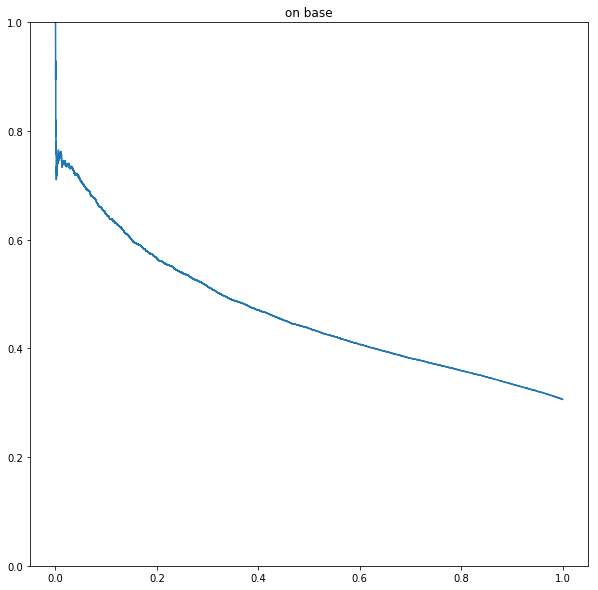

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

preds = linear_model.predict(X_t.values)
p, r, t = precision_recall_curve(y, preds)
ax.plot(r, p)
ax.set_ylim([0, 1])
_ = ax.set_title('on base')

# Getting deeper

## Define an encoder

To map IDs to valid range for `keras` embedding layers

In [65]:
from sklearn.base import TransformerMixin

class Encoder(TransformerMixin):
    def __init__(self):
        self.mappings = {}

    def fit(self, X):
        self.mappings = {
            feature: {v: i for i, v in enumerate(X[feature].unique())}
            for feature in X.columns
        }
        return self
    
    def transform(self, X):
        return {
            f'{feature}_input': X[feature].map(self.mappings[feature]).values
            for feature in X.columns
            if feature in self.mappings
        }

    def inverse_transform(self, X, feature):
        return X.map({v: k for k, v in self.mappings[feature].items()})
    
    def get_feature_dim(self, feature):
        return len(self.mappings[feature])

## Build batches for training

In [66]:
encoder = Encoder()
encoder.fit(df[categorical_features])

In [67]:
if False:
    sample_key = df[['game_pk', 'at_bat_number']].apply(lambda x: hash(tuple(x)) % 100, axis=1)
    df_sample = df[sample_key <= 10]
else:
    df_sample = df

In [68]:
df_sample.shape

(566962, 106)

Here we "featurize" each at-bat. In the following step we sort each at-bat by the number of pitches thrown and build the batches based on these groups so that we minimize padding during training.

In [70]:
from tqdm import tqdm_notebook as tqdm

df_sample.sort_values(['game_pk', 'at_bat_number', 'pitch_number'], inplace=True)

groups = df_sample.groupby([
    'game_pk', 'at_bat_number'
], as_index=False)
groups = list(groups)
np.random.shuffle(groups)

X_train = []
y_train = []

def featurize_at_bat(group):
    (game_pk, at_bat_number), group_df = group
    x = encoder.transform(group_df[categorical_features])
    x['numeric_inputs'] = group_df[numeric_features].values
    
    assert len(group_df.target.unique()) <= 2
    y = group_df.target.max().astype(int)
    
    y_aux = np.stack(group_df['auxillary_targets'])
    return x, y, y_aux, len(x['numeric_inputs'])

In [71]:
import multiprocessing as mp
import numpy as np

# this takes ridiculously long if not parallelized
pool = mp.Pool(2 * mp.cpu_count())
res = pool.imap_unordered(featurize_at_bat, tqdm(groups))
res = sorted(res, key=lambda x: x[-1])
X_train, y_train, y_aux_train, batch_lens = zip(*res)

In [72]:
len(X_train), len(y_train), len(y_aux_train)

(144994, 144994, 144994)

## Create a list of the batches

In [73]:
import numpy as np

# assign each at-bat an ID so that each batch
# has roughly 32 at-bats
batch_ids = np.cumsum(batch_lens) // (4 * 32)
len(batch_ids), len(set(batch_ids))

(144994, 4430)

In [74]:
batch_ids[:1000:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [75]:
from itertools import groupby
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train, y_aux_train), key=lambda x: next(i))

In [76]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

input_features = [
    f'{f}_input' for f in categorical_features
] + ['numeric_inputs']

def batch_generator(gb):
    for batch_id, batch in gb:
        xs, ys, ys_aux = zip(*list(batch))
        X_batch = {}
        for f in input_features:
            X_batch[f] = pad_sequences([x[f] for x in xs])
        y = np.array(ys)
        y_aux = np.array(ys_aux)
        yield X_batch, y, y_aux
        

In [77]:
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train, y_aux_train), key=lambda x: next(i))
batches = list(batch_generator(gb))

In [78]:
len(batches)

4430

In [79]:
batches[0][0]['numeric_inputs'].shape, batches[0][1].shape, batches[0][2].shape

((127, 1, 25), (127,), (127, 1, 3))

In [80]:
batches[-1][0]['numeric_inputs'].shape, batches[-1][1].shape, batches[-1][2].shape

((3, 21, 25), (3,), (3,))

In [81]:
i_range = iter(range(len(batches)))

In [82]:
i = next(i_range)
batches[i][0]['numeric_inputs'].shape, batches[i][1].shape, batches[i][2].shape

((127, 1, 25), (127,), (127, 1, 3))

# Hybrid model

In [83]:
import keras
import keras.backend as K

# LSTM input
Sum = keras.layers.Lambda(lambda x: K.sum(x, axis=1))
def Attention(X):
    # https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf
    W = keras.layers.Dense(K.int_shape(X)[-1], activation='tanh', name='W')
    u = W(X)
    u_w = keras.layers.Dense(1, activation='linear', name='u_w')
    attention = keras.layers.Softmax(1)(u_w(u))
    X_attended = keras.layers.Multiply()([X, attention])
    return Sum(X_attended), attention


categorical_dimmensions = {
    'batter_id': 1,
    'pitcher_id': 1,
}

numeric_input = keras.layers.Input((None, len(numeric_features),), name='numeric_inputs')
X_numeric_input = keras.layers.BatchNormalization()(numeric_input)

categorical_inputs = []
embeddings = {}
for feature in categorical_features:
    input_ = keras.layers.Input((None,), name=f'{feature}_input')
    output_dim = categorical_dimmensions.get(feature, 1)
    embedding =  keras.layers.Embedding(input_dim=encoder.get_feature_dim(feature) + 1,
                                        output_dim=output_dim,
                                        name=f'{feature}_embedding')(input_)
    categorical_inputs.append(input_)
    embeddings[feature] = embedding

# Average is just a hacky way to get these embeddings 2D.
Avg = keras.layers.Lambda(lambda x: K.mean(x, axis=1))
batter_embedding = Avg(embeddings.pop('batter_id'))
pitcher_embedding = Avg(embeddings.pop('pitcher_id'))
X_embeddings = keras.layers.Concatenate(axis=-1)(list(embeddings.values()))

X = keras.layers.Concatenate()([X_numeric_input, X_embeddings])
X = keras.layers.BatchNormalization()(X)
X_lstm = keras.layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)(X)
X, attention = Attention(X_lstm)
X = keras.layers.Concatenate()([
    X,
    pitcher_embedding,
    batter_embedding
])
X = keras.layers.Dense(1, activation='sigmoid', name='y')(X)

hybrid_model = keras.models.Model(
    inputs=[numeric_input] + list(categorical_inputs),
    outputs=X)

In [84]:
hybrid_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
if_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
of_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
inning_topbot_input (InputLayer (None, None)         0                                            
__________________________________________________________________________________________________
pitch_name_input (InputLayer)   (None, None)         0                                            
__________________________________________________________________________________________________
zone_input

In [86]:
hybrid_model.compile(loss='binary_crossentropy', optimizer='adam')

In [87]:
L = []
def g():
    while True:
        np.random.shuffle(batches)
        for X, y, y_aux in batches:
            if len(y_aux.shape) != 3:
                L.append(None)
                continue
            yield X, y
hybrid_model.fit_generator(g(), steps_per_epoch=len(batches), epochs=3)

Epoch 1/3
4430/4430 [==============================] - 39s 9ms/step - loss: 0.5586
Epoch 2/3
4430/4430 [==============================] - 37s 8ms/step - loss: 0.5287
Epoch 3/3
4430/4430 [==============================] - 37s 8ms/step - loss: 0.5213


In [88]:
len(L)

42

## P/R curves

In [89]:
preds = np.concatenate([hybrid_model.predict(x) for x, _, _ in batches])
y_all = np.concatenate([y for _, y, _ in batches])

In [90]:
y_all.mean(axis=0)

0.30497813702635973

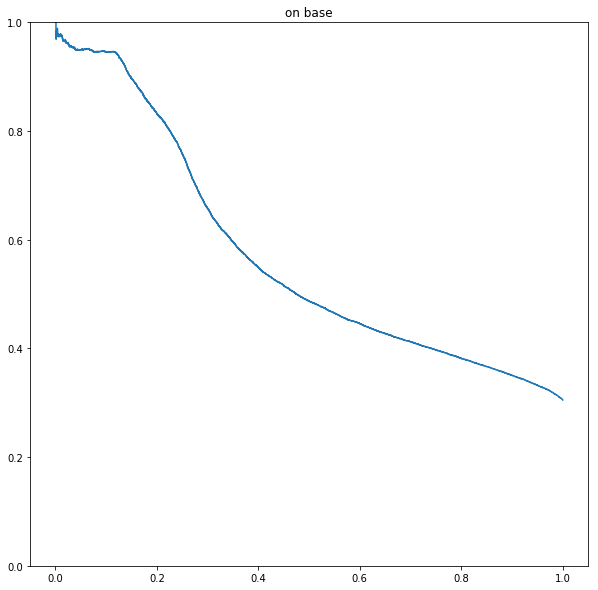

In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

p, r, t = precision_recall_curve(y_all, preds)
ax.plot(r, p)
ax.set_ylim([0, 1])
_ = ax.set_title('on base')

## Defining utility functions

In [93]:
def get_feature_embeddings(X, feature, model):
    input_ = encoder.transform(X)[f'{feature}_input']
    return get_embeddings(input_, model, feature)

def get_embeddings(X, model, feature):
    input_ = model.get_layer(f'{feature}_input').get_output_at(-1)
    encoding = model.get_layer(f'{feature}_embedding').get_output_at(-1)
    return keras.models.Model(inputs=input_, outputs=encoding).predict(X)

## Look at embeddings

In [96]:
hybrid_model.get_layer('y').get_weights()[0][-1]

array([-0.8219622], dtype=float32)

In [97]:
batters = df[['batter_id', 'batter_mlbname']].drop_duplicates()
batters = batters.merge(stats, left_on='batter_id', right_on='batter_mlbid')
batters = batters[batters.AB > 100]
batter_embeddings = get_feature_embeddings(batters, 'batter_id', hybrid_model).reshape(-1)
batter_coefs = hybrid_model.get_layer('y').get_weights()[0][-1]
batters['prob_on_base'] = batter_embeddings * batter_coefs
batters.sort_values('prob_on_base', ascending=False).head(10)

,batter_id,batter_mlbname,batter_mlbid,H,BB,HBP,2B,3B,HR,SF,AB,1B,obp,slg,ops,prob_on_base
0,605141.0,Mookie Betts,605141.0,180,81,8.0,47,5,32,5.0,520,170,0.438111,0.782692,1.220803,0.344889
92,514888.0,Jose Altuve,514888.0,169,55,6.0,29,2,13,1.0,534,155,0.385906,0.507491,0.893397,0.305390
109,545361.0,Mike Trout,545361.0,147,122,10.0,24,4,39,4.0,471,166,0.459638,0.811040,1.270678,0.303726
125,456715.0,Lorenzo Cain,456715.0,166,71,8.0,25,2,10,2.0,539,153,0.395161,0.461967,0.857128,0.270927
207,408234.0,Miguel Cabrera,408234.0,40,22,0.0,11,0,3,1.0,134,32,0.394904,0.492537,0.887442,0.253487
190,518692.0,Freddie Freeman,518692.0,191,76,7.0,44,4,23,6.0,618,174,0.387553,0.592233,0.979786,0.253050
59,516416.0,Jean Segura,516416.0,178,32,4.0,29,3,10,6.0,586,162,0.340764,0.459044,0.799809,0.247472
381,643446.0,Jeff McNeil,643446.0,74,14,5.0,11,6,3,0.0,225,72,0.381148,0.551111,0.932259,0.245493
71,453568.0,Charlie Blackmon,453568.0,182,59,8.0,31,7,29,2.0,626,187,0.358273,0.616613,0.974887,0.234101
297,605480.0,Mallex Smith,605480.0,142,47,8.0,27,10,2,2.0,480,127,0.366853,0.456250,0.823103,0.225483


In [98]:
hybrid_model.get_layer('y').get_weights()[0][-2]

array([-0.928786], dtype=float32)

In [101]:
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
pitchers = pitchers.merge(pitching_stats, left_on='pitcher_id', right_on='pitcher_mlbid')
pitcher_embeddings = get_feature_embeddings(pitchers, 'pitcher_id', hybrid_model).reshape(-1)
pitcher_coefs = hybrid_model.get_layer('y').get_weights()[0][-2]
pitchers['prob_not_on_base'] = pitcher_embeddings * pitcher_coefs
pitchers[pitchers.IP > 100].sort_values('prob_not_on_base', ascending=True).head(10)

,pitcher_id,player_name,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,prob_not_on_base
320,621111.0,Walker Buehler,621111.0,137.333333,37,95,40,2.621359,0.961165,-0.399014
129,605483.0,Blake Snell,605483.0,180.666667,64,112,38,1.892989,0.974170,-0.343194
230,594798.0,Jacob deGrom,594798.0,217.000000,46,152,41,1.700461,0.912442,-0.323697
26,446372.0,Corey Kluber,446372.0,215.000000,34,179,69,2.888372,0.990698,-0.299530
294,656794.0,Sean Newcomb,656794.0,164.000000,81,137,71,3.896341,1.329268,-0.288363
399,605397.0,Joe Musgrove,605397.0,115.333333,23,113,52,4.057803,1.179191,-0.283082
130,456034.0,David Price,456034.0,176.000000,50,151,70,3.579545,1.142045,-0.264332
122,453286.0,Max Scherzer,453286.0,220.666667,51,150,62,2.528701,0.910876,-0.253651
161,468504.0,Jhoulys Chacin,468504.0,192.666667,71,153,75,3.503460,1.162630,-0.253553
41,434378.0,Justin Verlander,434378.0,214.000000,37,156,60,2.523364,0.901869,-0.234012


In [102]:
pitchers[pitchers.IP < 100].sort_values('prob_not_on_base', ascending=True).head(10)

,pitcher_id,player_name,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,prob_not_on_base
197,451584.0,Wade Davis,451584.0,65.333333,26,43,30,4.132653,1.056122,-0.458911
42,600917.0,Jose Leclerc,600917.0,57.666667,25,24,10,1.560694,0.849711,-0.455696
299,456696.0,David Hernandez,456696.0,64.000000,17,46,18,2.531250,0.984375,-0.443430
345,543507.0,Trevor May,543507.0,25.333333,5,21,9,3.197368,1.026316,-0.424098
372,592468.0,Nick Kingham,592468.0,76.000000,26,79,44,5.210526,1.381579,-0.390648
11,467008.0,Pedro Strop,467008.0,59.666667,21,38,15,2.262570,0.988827,-0.374075
128,448281.0,Sean Doolittle,448281.0,45.000000,6,21,8,1.600000,0.600000,-0.356485
83,476454.0,Dellin Betances,476454.0,66.666667,26,44,20,2.700000,1.050000,-0.348524
30,621242.0,Edwin Diaz,621242.0,73.333333,17,41,16,1.963636,0.790909,-0.341777
38,493603.0,Adam Ottavino,493603.0,77.666667,36,41,21,2.433476,0.991416,-0.341349


# Recurrent model

In [104]:
import keras
import keras.backend as K

# LSTM input
Sum = keras.layers.Lambda(lambda x: K.sum(x, axis=1))
def Attention(X):
    # https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf
    W = keras.layers.Dense(K.int_shape(X)[-1], activation='tanh', name='W')
    u = W(X)
    u_w = keras.layers.Dense(1, activation='linear', name='u_w')
    attention = keras.layers.Softmax(1)(u_w(u))
    X_attended = keras.layers.Multiply()([X, attention])
    return Sum(X_attended), attention


categorical_dimmensions = {
    'batter_id': 4,
    'pitcher_id': 2,
}

numeric_input = keras.layers.Input((None, len(numeric_features),), name='numeric_inputs')
X_numeric_input = keras.layers.BatchNormalization()(numeric_input)

categorical_inputs = []
embeddings = {}
for feature in categorical_features:
    input_ = keras.layers.Input((None,), name=f'{feature}_input')
    output_dim = categorical_dimmensions.get(feature, 1)
    embedding =  keras.layers.Embedding(input_dim=encoder.get_feature_dim(feature) + 1,
                                        output_dim=output_dim,
                                        name=f'{feature}_embedding')(input_)
    categorical_inputs.append(input_)
    embeddings[feature] = embedding

X_embeddings = keras.layers.Concatenate(axis=-1)(list(embeddings.values()))
X = keras.layers.Concatenate()([X_numeric_input, X_embeddings])
X = keras.layers.BatchNormalization()(X)
X_lstm = keras.layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)(X)
X, attention = Attention(X_lstm)
X = keras.layers.Dense(1, activation='sigmoid', name='y')(X)

X_aux = keras.layers.Dense(32, activation='relu')(X_lstm)
X_aux = keras.layers.BatchNormalization()(X_aux)
X_aux = keras.layers.Dense(32, activation='relu')(X_aux)
X_aux = keras.layers.BatchNormalization()(X_aux)
X_aux = keras.layers.Dense(len(auxillary_targets), name='y_aux')(X_aux)

nonlinear_model = keras.models.Model(
    inputs=[numeric_input] + list(categorical_inputs),
    outputs=[X, X_aux])

In [105]:
nonlinear_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
if_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
of_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
inning_topbot_input (InputLayer (None, None)         0                                            
__________________________________________________________________________________________________
pitch_name_input (InputLayer)   (None, None)         0                                            
__________________________________________________________________________________________________
zone_input

In [108]:
nonlinear_model.compile(loss={'y': 'binary_crossentropy', 'y_aux': 'mse'}, optimizer='adam', loss_weights={'y': 1., 'y_aux': 3.})

In [109]:
L = []
def g():
    while True:
        np.random.shuffle(batches)
        for X, y, y_aux in batches:
            if len(y_aux.shape) != 3:
                L.append(None)
                continue
            yield X, {'y': y, 'y_aux': y_aux}
nonlinear_model.fit_generator(g(), steps_per_epoch=len(batches), epochs=3)

Epoch 1/3
4430/4430 [==============================] - 43s 10ms/step - loss: 1.4534 - y_loss: 0.5855 - y_aux_loss: 0.2893
Epoch 2/3
4430/4430 [==============================] - 40s 9ms/step - loss: 1.3187 - y_loss: 0.5394 - y_aux_loss: 0.2598
Epoch 3/3
4430/4430 [==============================] - 40s 9ms/step - loss: 1.2943 - y_loss: 0.5268 - y_aux_loss: 0.2558


In [110]:
len(L)

42

## P/R curves

In [111]:
preds = np.concatenate([nonlinear_model.predict(x)[0] for x, _, _ in batches])
y_all = np.concatenate([y for _, y, _ in batches])

In [112]:
y_all.mean(axis=0)

0.30497813702635973

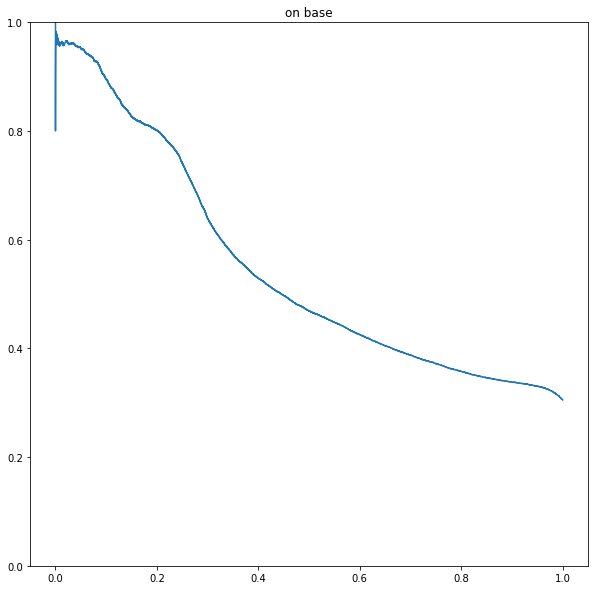

In [134]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

p, r, t = precision_recall_curve(y_all, preds)
ax.plot(r, p)
ax.set_ylim([0, 1])
_ = ax.set_title('on base')

# Inspect model

## Pitcher embeddings

In [114]:
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
pitchers = pitching_stats.merge(pitchers, left_on='pitcher_mlbid', right_on='pitcher_id')
pitcher_embeddings = get_feature_embeddings(pitchers, 'pitcher_id', nonlinear_model)
pitchers['x'], pitchers['y'] = zip(*pitcher_embeddings.reshape((-1, 2)))

In [115]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform

output_notebook()

lookat =  'WHIP'

source = ColumnDataSource(
        data=dict(
            x=pitchers.x,
            y=pitchers.y,
            desc=pitchers.player_name,
            WHIP=pitchers.WHIP
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256[::-1], low=pitchers[lookat].min(), high=pitchers[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)

Loading BokehJS ...

## Look at batter embeddings

In [116]:
from sklearn.manifold import TSNE
batters = df[['batter_id', 'batter_mlbname']].drop_duplicates()
batters = batters.merge(stats, left_on='batter_id', right_on='batter_mlbid')
batters = batters[batters.AB > 100]
batter_embeddings = get_feature_embeddings(batters, 'batter_id', nonlinear_model)
batters['x'], batters['y'] = zip(*TSNE(2).fit_transform(batter_embeddings.reshape((-1, 4))))

In [117]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()

lookat = {
    'Mike Trout': 'red',
    'Christian Yelich': 'green',
    'Bryce Harper': 'orange',
    'Mookie Betts': 'pink',
    'Rhys Hoskins': 'purple',
    'Jean Segura': 'grey'
}

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom'],
           title="Mouse over the dots")

transformer = CategoricalColorMapper(
    factors=list(lookat.keys()),
    palette=list(lookat.values()),
    nan_color='blue')
p.circle('x', 'y', size=10, source=source, fill_color=transform('desc', transformer))
show(p)


Loading BokehJS ...

In [118]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()


lookat = 'slg'

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname,
            slg=batters.slg,
            obp=batters.obp,
            ops=batters.ops,
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom', 'box_zoom'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=batters[lookat].min(), high=batters[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)


Loading BokehJS ...

In [119]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()


lookat = 'ops'

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname,
            slg=batters.slg,
            obp=batters.obp,
            ops=batters.ops,
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom', 'box_zoom'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=batters[lookat].min(), high=batters[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)


Loading BokehJS ...

## Look at attention

In [182]:
attention_model = keras.models.Model(inputs=[numeric_input] + list(categorical_inputs), outputs=attention)

In [183]:
batch_idx = 2
bx, by, _ = batches[batch_idx]
aa = np.squeeze(attention_model.predict(bx))
bx['numeric_inputs'].shape, aa.shape

((25, 5, 25), (25, 5))

In [122]:
aa

array([[3.78150067e-13, 5.87294089e-14, 1.60237343e-13, 2.27536759e-07,
        9.99999762e-01],
       [8.73404994e-12, 2.51703801e-12, 7.90370634e-12, 2.97307679e-06,
        9.99997020e-01],
       [1.22969874e-12, 2.90488987e-13, 1.05362225e-12, 3.67111340e-07,
        9.99999642e-01],
       [2.50576816e-11, 8.16301540e-12, 1.26192980e-11, 1.01832347e-06,
        9.99998927e-01],
       [6.62585889e-11, 3.19333067e-11, 9.14941595e-11, 1.78114453e-06,
        9.99998212e-01],
       [4.52640139e-12, 8.39665414e-13, 3.69029893e-12, 1.49946814e-07,
        9.99999881e-01],
       [3.70604963e-10, 1.09482937e-10, 5.93183669e-10, 6.91056675e-06,
        9.99993086e-01],
       [2.20593292e-12, 8.61216805e-13, 1.18531617e-11, 2.82092174e-07,
        9.99999762e-01],
       [1.01362425e-11, 4.79921311e-12, 9.27725258e-11, 8.14360556e-06,
        9.99991894e-01],
       [4.96676832e-12, 7.31990694e-13, 2.78904981e-12, 1.21377951e-07,
        9.99999881e-01],
       [9.06349702e-13, 2.9267

In [123]:
np.argmax(aa, axis=1)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4])

In [142]:
p = nonlinear_model.predict(bx)
p[0].shape

(25, 1)

In [143]:
def inverse_transform(X):
    d = pd.DataFrame(X['numeric_inputs'], columns=numeric_features)
    for f in categorical_features:
        d[f] = encoder.inverse_transform(pd.Series(X[f'{f}_input']), f)
    return d

In [144]:
bx

{'if_fielding_alignment_input': array([[2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 0, 2, 2, 2],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0],
        [2, 2, 2, 2, 2],
        [0, 0, 0, 0, 0],
        [1, 2, 2, 2, 1],
        [1, 1, 2, 2, 2],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0],
        [2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2]], dtype=int32),
 'of_fielding_alignment_input': array([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1],
        [1, 1, 1, 1, 1]

In [145]:
idx = 0

In [165]:
idx += 1
d = inverse_transform({k: v[idx] for k, v in bx.items()})
d['attention'] = aa[idx].reshape(-1)
d = d.merge(batters[['batter_id', 'batter_mlbname']])
d = d.merge(pitchers[['pitcher_id', 'player_name']])

print('was', 'on base' if by[idx] == 1 else 'not on base event')
print('predicted', 'on base' if p[0][idx] > 0.5 else 'not on base')

with pd.option_context('display.max_columns', None):
    display(d)

was on base
predicted on base


,bat_score,fld_score,balls,strikes,outs_when_up,pitch_number,inning,total_pitch_number,at_bat_number,ax,ay,az,pfx_x,pfx_z,vx0,vy0,vz0,release_speed,release_spin_rate,release_pos_x,release_pos_y,plate_x,plate_z,sz_top,sz_bot,if_fielding_alignment,of_fielding_alignment,inning_topbot,pitch_name,zone,pitcher_id,batter_id,game_type,stand,runner_on_first,runner_on_second,runner_on_third,away_team,home_team,p_throws,attention,batter_mlbname,player_name
0,6,0,0,0,2,1,6,1,48,-19,34,-21,-1,0,7,-142,-2,98,2225,-2,54,0,3,3,1,Standard,Standard,Bot,Sinker,1.0,612434.0,605141.0,R,R,1,0,0,BAL,BOS,R,4.780374e-13,Mookie Betts,Miguel Castro
1,6,0,0,1,2,2,6,2,48,0,26,-31,0,0,8,-126,-2,87,2978,-2,54,1,2,3,1,Standard,Standard,Bot,Slider,14.0,612434.0,605141.0,R,R,1,0,0,BAL,BOS,R,2.527387e-13,Mookie Betts,Miguel Castro
2,6,0,1,1,2,3,6,3,48,-1,25,-31,0,0,10,-127,-4,88,2909,-2,54,1,1,3,1,Standard,Standard,Bot,Slider,14.0,612434.0,605141.0,R,R,1,0,0,BAL,BOS,R,6.747378e-13,Mookie Betts,Miguel Castro
3,6,0,2,1,2,4,6,4,48,-24,32,-22,-1,0,14,-142,-8,98,2556,-2,54,1,0,2,1,Standard,Standard,Bot,Sinker,14.0,612434.0,605141.0,R,R,1,0,0,BAL,BOS,R,1.071408e-07,Mookie Betts,Miguel Castro
4,6,0,3,1,2,5,6,5,48,-18,33,-23,-1,0,6,-139,-3,96,2292,-2,54,-1,2,3,1,Standard,Standard,Bot,Sinker,13.0,612434.0,605141.0,R,R,1,0,0,BAL,BOS,R,9.999999e-01,Mookie Betts,Miguel Castro


In [200]:
atbat = df.merge(
    df[['game_pk', 'at_bat_number']].drop_duplicates().sample(1),
    on=['game_pk', 'at_bat_number'])
atbat

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,...,pitcher_idplayer,target,auxillary_targets,runner_on_first,runner_on_second,runner_on_third,counter,total_pitch_number,batter_id,pitcher_id
0,70.0,4.0,LAD,-18.2348,26.7791,-23.8947,NaN,0.0,4.0,571970.0,...,hugheph01,0,"[0.0, 0.0, 0.0]",1,0,0,1,5,571970.0,461833.0
1,70.0,4.0,LAD,-19.3347,27.3434,-24.7603,NaN,1.0,4.0,571970.0,...,hugheph01,0,"[0.0, 0.0, 0.0]",1,0,0,1,6,571970.0,461833.0
2,70.0,4.0,LAD,-1.8332,23.9523,-19.9862,NaN,2.0,4.0,571970.0,...,hugheph01,0,"[0.0, 0.0, 0.0]",1,0,0,1,7,571970.0,461833.0
3,70.0,4.0,LAD,-17.9261,26.2905,-22.7783,NaN,2.0,4.0,571970.0,...,hugheph01,0,"[0.14226133297166826, -0.5691250334299099, 0.3...",1,0,0,1,8,571970.0,461833.0
4,70.0,4.0,LAD,-10.0236,23.0776,-18.8722,0.0,2.0,4.0,571970.0,...,hugheph01,0,"[1.540982551106028, 0.9603414505679234, 0.7454...",1,0,0,1,9,571970.0,461833.0


In [201]:
xx = featurize_at_bat(((None, None), atbat))[0]
xx = {k: np.expand_dims(v, axis=0) for k, v in xx.items()}
pp = nonlinear_model.predict(xx)[0][0]
aa = attention_model.predict(xx)

In [203]:
atbat['attention'] = aa.reshape(-1)
with pd.option_context('display.max_columns', None):
    print('predicted on base with probability:', pp)
    print(atbat.iloc[-1].des)
    display(atbat[['des', 'attention'] + categorical_features + numeric_features])

predicted on base with probability: [0.16241316]
Max Muncy flies out to center fielder Travis Jankowski.  


,des,attention,if_fielding_alignment,of_fielding_alignment,inning_topbot,pitch_name,zone,pitcher_id,batter_id,game_type,stand,runner_on_first,runner_on_second,runner_on_third,away_team,home_team,p_throws,bat_score,fld_score,balls,strikes,outs_when_up,pitch_number,inning,total_pitch_number,at_bat_number,ax,ay,az,pfx_x,pfx_z,vx0,vy0,vz0,release_speed,release_spin_rate,release_pos_x,release_pos_y,plate_x,plate_z,sz_top,sz_bot
0,NaN,1.060211e-12,Infield shift,Standard,Top,2-Seam Fastball,11.0,461833.0,571970.0,R,L,1,0,0,LAD,SD,R,4.0,2.0,0.0,0.0,1.0,1.0,9.0,5,70.0,-18.2348,26.7791,-23.8947,-1.5549,0.7205,4.4231,-130.4808,-2.4296,89.7,2110.0,-1.9361,54.9124,-1.4132,2.9205,3.0010,1.4475
1,NaN,2.582694e-13,Infield shift,Standard,Top,2-Seam Fastball,11.0,461833.0,571970.0,R,L,1,0,0,LAD,SD,R,4.0,2.0,1.0,0.0,1.0,2.0,9.0,6,70.0,-19.3347,27.3434,-24.7603,-1.6260,0.6266,4.8449,-130.9980,-2.8590,90.1,2100.0,-1.9780,54.7890,-1.3602,2.7235,3.0178,1.4307
2,NaN,2.621511e-12,Infield shift,Standard,Top,Cutter,6.0,461833.0,571970.0,R,L,1,0,0,LAD,SD,R,4.0,2.0,2.0,0.0,1.0,3.0,9.0,7,70.0,-1.8332,23.9523,-19.9862,-0.0578,1.1020,6.4443,-126.6612,-3.7212,87.1,2109.0,-1.9549,54.6758,0.7064,2.3856,3.2563,1.3971
3,NaN,1.400773e-06,Infield shift,Standard,Top,2-Seam Fastball,11.0,461833.0,571970.0,R,L,1,0,0,LAD,SD,R,4.0,2.0,2.0,1.0,1.0,4.0,9.0,8,70.0,-17.9261,26.2905,-22.7783,-1.4917,0.7816,5.3355,-130.8436,-3.9680,90.0,1944.0,-1.8690,54.7208,-0.9420,2.4000,3.2563,1.3971
4,Max Muncy flies out to center fielder Travis J...,9.999986e-01,Infield shift,Standard,Top,4-Seam Fastball,8.0,461833.0,571970.0,R,L,1,0,0,LAD,SD,R,4.0,2.0,2.0,2.0,1.0,5.0,9.0,9,70.0,-10.0236,23.0776,-18.8722,-0.7929,1.1339,6.8515,-128.8370,-5.1660,88.6,2102.0,-1.9560,54.5447,0.2031,1.8475,3.2563,1.3971


# counterfactuals

In [ ]:
nonlinear_model.inputs

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import log_loss

def make_loss(model, y_new, x_old, lambda_):
    x_base = {k: v for k, v in x_old.items()}
    x_shape = x_base['numeric_inputs'].shape
    def loss(x):
        x = x.reshape(x_shape)
        x_base['numeric_inputs'] = x
        y_hat = model.predict(x_base).reshape(-1)
        L = lambda_ * log_loss(y_new, y_hat)
        d = np.sum((x - x_old['numeric_inputs']) ** 2)
        return L + d
    return loss

In [ ]:
batch_idx = 0
idx = 0
bx, by, _ = batches[batch_idx]
x_old = {k: np.expand_dims(v[idx], 0) for k, v in bx.items()}
loss = make_loss(
    model,
    np.array([0, 0, 0, 0, 0, 1]),
    x_old,
    2)
minimize(loss, x_old['numeric_inputs'], method='Nelder-Mead')